## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
ira_data = ira_data[(ira_data['AD_IMPRESSIONS']> 0) & ira_data['AD_CLICKS'] > 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def time_to_ms(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1000 / 1000

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: time_to_ms(x))
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','').astype('float')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

2395

### Remove hyperlinks

In [9]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d90f748>,
      dtype=object)

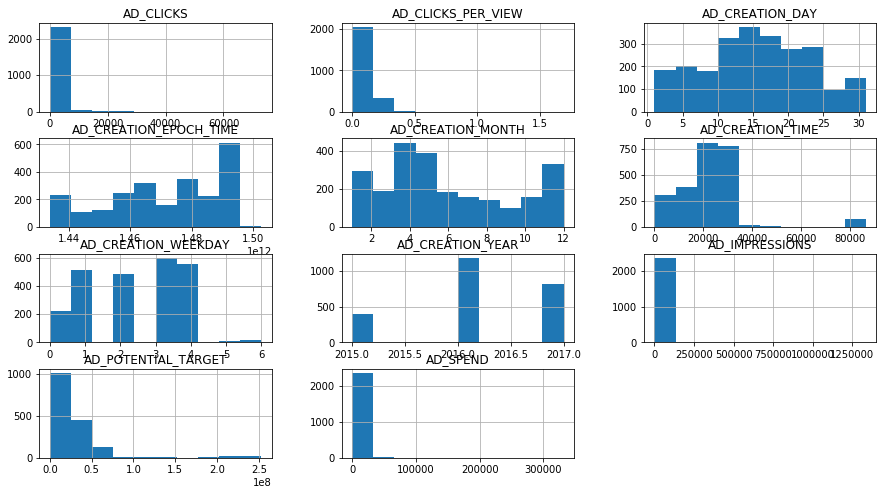

In [10]:
ira_data.hist()

### Select all duplicate ad texts

In [11]:
ira_data['Duplicate'] = ira_data['AD_TEXT'].duplicated(keep=False)

### Total Duplicates

In [12]:
ira_data['AD_TEXT'].count()

2395

In [13]:
ira_data['Duplicate'].value_counts()

False    1889
True      506
Name: Duplicate, dtype: int64

### Unique Duplicate Pairs

In [14]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].nunique()

184

### Occurence of Duplicate Pairs

In [15]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].value_counts().values

array([13,  9,  8,  7,  6,  6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [16]:
ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,
580,103.0,122.0,2015-06-16 03:36:10,1,2015,6,16,12970.0,We speak for all fellow members of LGBT commun...,129.66,35000000.0
581,36.0,1438.0,2015-06-17 03:15:18,2,2015,6,17,11718.0,We speak for all fellow members of LGBT commun...,1362.57,144000000.0
582,1724.0,18891.0,2015-06-18 00:58:48,3,2015,6,18,3528.0,We speak for all fellow members of LGBT commun...,10085.77,35000000.0
583,186.0,4265.0,2015-06-22 08:19:07,0,2015,6,22,29947.0,We speak for all fellow members of LGBT commun...,1393.55,139000000.0
584,3206.0,31618.0,2015-06-23 05:06:57,1,2015,6,23,18417.0,We speak for all fellow members of LGBT commun...,16630.20,143000000.0
585,1252.0,11857.0,2015-07-01 02:55:07,2,2015,7,1,10507.0,We speak for all fellow members of LGBT commun...,5538.24,165000000.0
586,59.0,1811.0,2015-07-07 01:51:07,1,2015,7,7,6667.0,We speak for all fellow members of LGBT commun...,757.65,166000000.0
587,542.0,15175.0,2015-07-09 01:50:28,3,2015,7,9,6628.0,We speak for all fellow members of LGBT commun...,6201.70,35000000.0
588,21449.0,175460.0,2015-07-14 00:01:38,1,2015,7,14,98.0,We speak for all fellow members of LGBT commun...,93754.38,41000000.0


### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

### Correlations
**TODO** Handling of Outliers?, beautify the plot (axis labels, etc.), correlation of time

In [17]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

In [18]:
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY']])) < float(std_dev)).all(axis=1)]

In [19]:
corrDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1561 entries, 1 to 3517
Data columns (total 11 columns):
AD_CLICKS                 1561 non-null float64
AD_IMPRESSIONS            1561 non-null float64
AD_CLICKS_PER_VIEW        1561 non-null float64
AD_SPEND                  1561 non-null float64
AD_POTENTIAL_TARGET       1561 non-null float64
AD_CREATION_WEEKDAY       1561 non-null int64
AD_CREATION_EPOCH_TIME    1561 non-null float64
AD_CREATION_YEAR          1561 non-null int64
AD_CREATION_MONTH         1561 non-null int64
AD_CREATION_DAY           1561 non-null int64
AD_CREATION_TIME          1561 non-null float64
dtypes: float64(7), int64(4)
memory usage: 146.3 KB


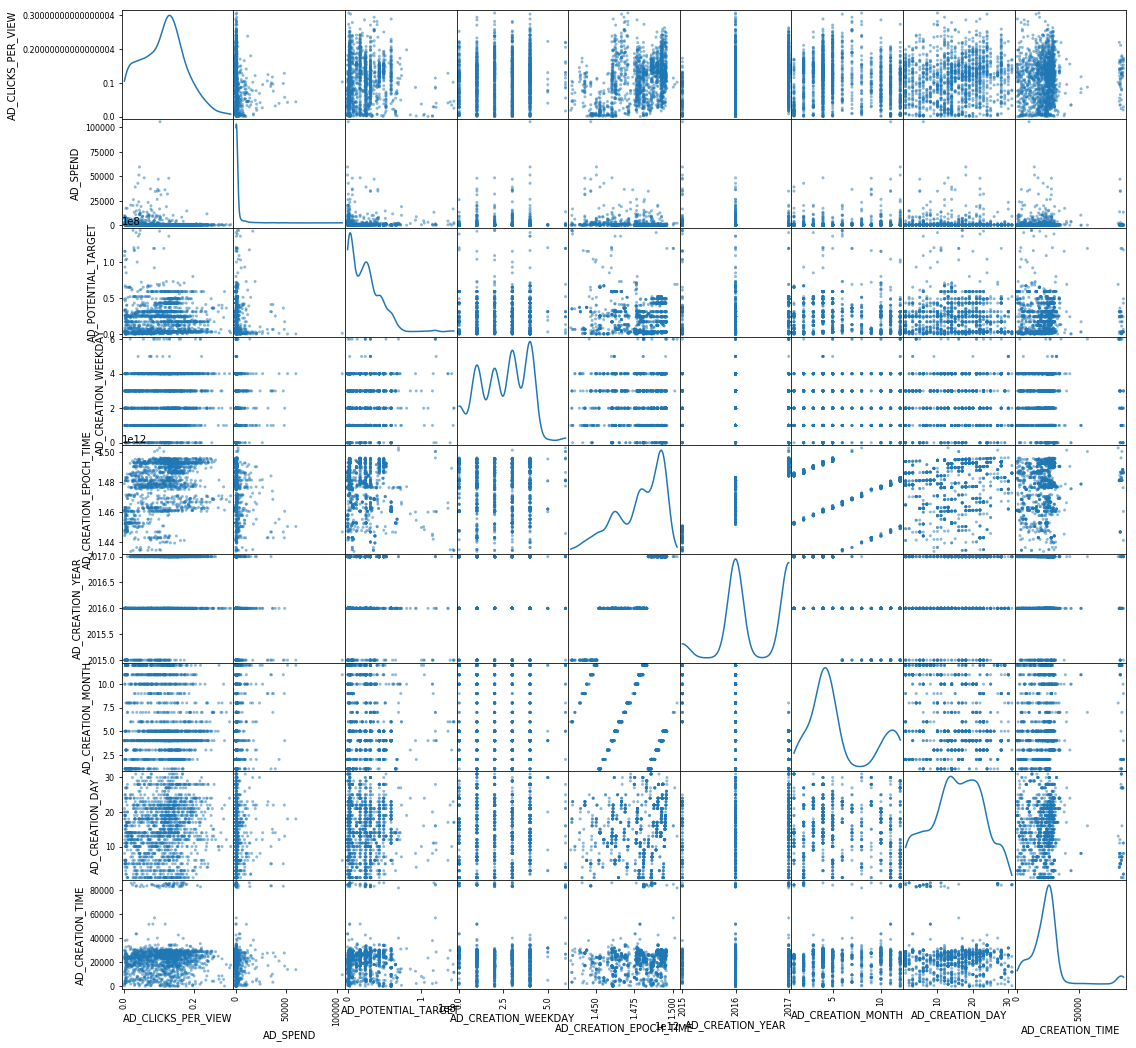

In [20]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterALL.png")

In [21]:
corr = corrDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
corr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.774459,0.276032,0.312826,0.082201,0.234158,0.215610,-0.062069,-0.003416,0.095631
AD_IMPRESSIONS,0.774459,1.000000,-0.065630,0.543079,0.041728,0.057677,0.052223,-0.011018,-0.035323,0.032362
AD_CLICKS_PER_VIEW,0.276032,-0.065630,1.000000,-0.152962,-0.010226,0.355368,0.323261,-0.096563,0.154860,0.080396
AD_SPEND,0.312826,0.543079,-0.152962,1.000000,-0.067132,-0.210235,-0.211786,0.097488,-0.043595,-0.010906
AD_POTENTIAL_TARGET,0.082201,0.041728,-0.010226,-0.067132,1.000000,-0.154291,-0.083515,-0.081568,-0.016343,-0.038136
AD_CREATION_EPOCH_TIME,0.234158,0.057677,0.355368,-0.210235,-0.154291,1.000000,0.890258,-0.214027,0.193047,0.132188
AD_CREATION_YEAR,0.215610,0.052223,0.323261,-0.211786,-0.083515,0.890258,1.000000,-0.634262,0.202631,0.048024
AD_CREATION_MONTH,-0.062069,-0.011018,-0.096563,0.097488,-0.081568,-0.214027,-0.634262,1.000000,-0.176425,0.122433
AD_CREATION_DAY,-0.003416,-0.035323,0.154860,-0.043595,-0.016343,0.193047,0.202631,-0.176425,1.000000,-0.033065
AD_CREATION_TIME,0.095631,0.032362,0.080396,-0.010906,-0.038136,0.132188,0.048024,0.122433,-0.033065,1.000000


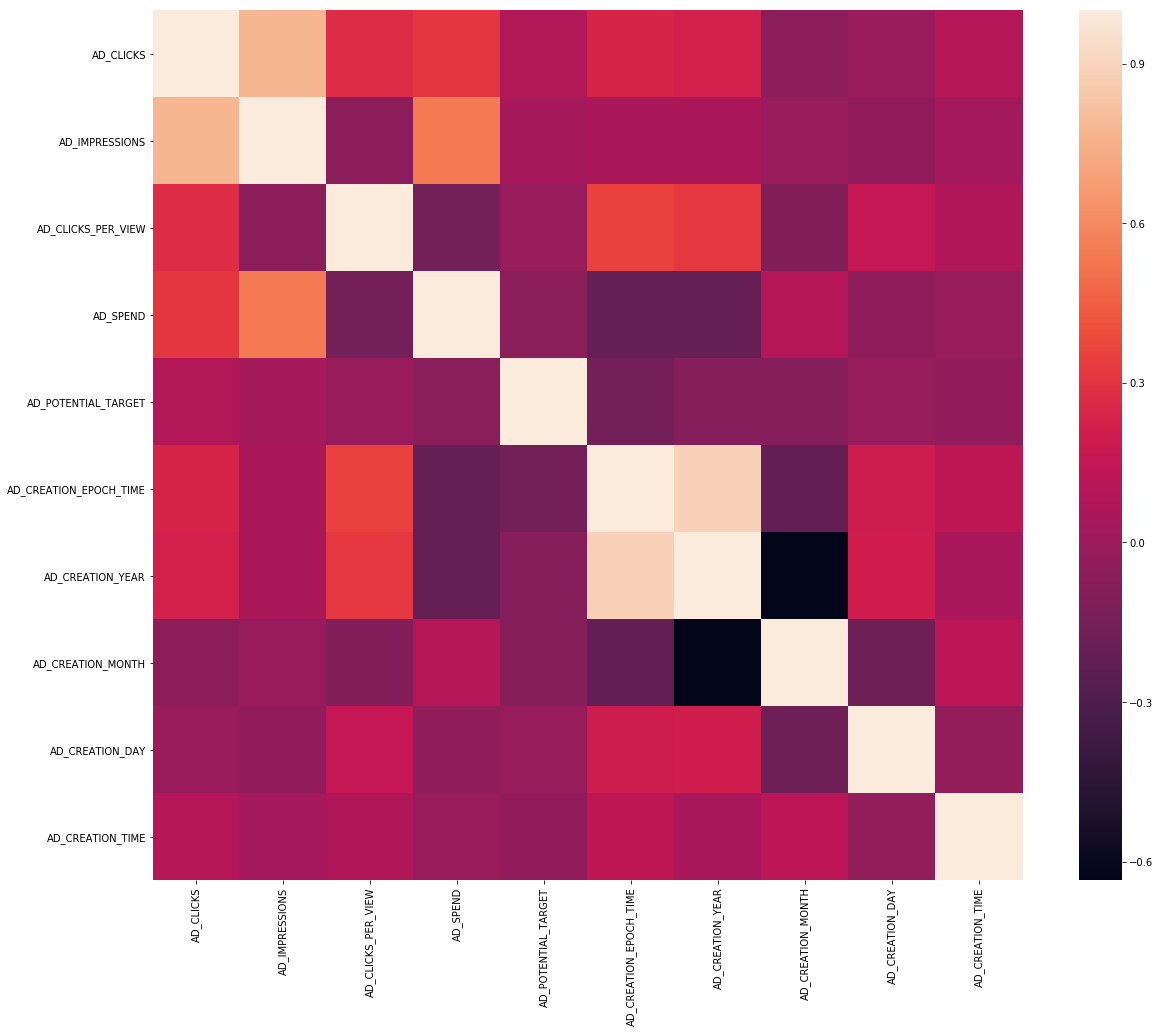

In [22]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(corr,ax=ax,square=True);

In [23]:
corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.890972,0.491061,0.067645
AD_IMPRESSIONS,0.890972,1.000000,0.143829,0.046365
AD_CLICKS_PER_VIEW,0.491061,0.143829,1.000000,0.072965
AD_CREATION_WEEKDAY,0.067645,0.046365,0.072965,1.000000


#### Correlation: Unique Dataset

In [24]:
corrUniqueDf = ira_data[ira_data['Duplicate']==False][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

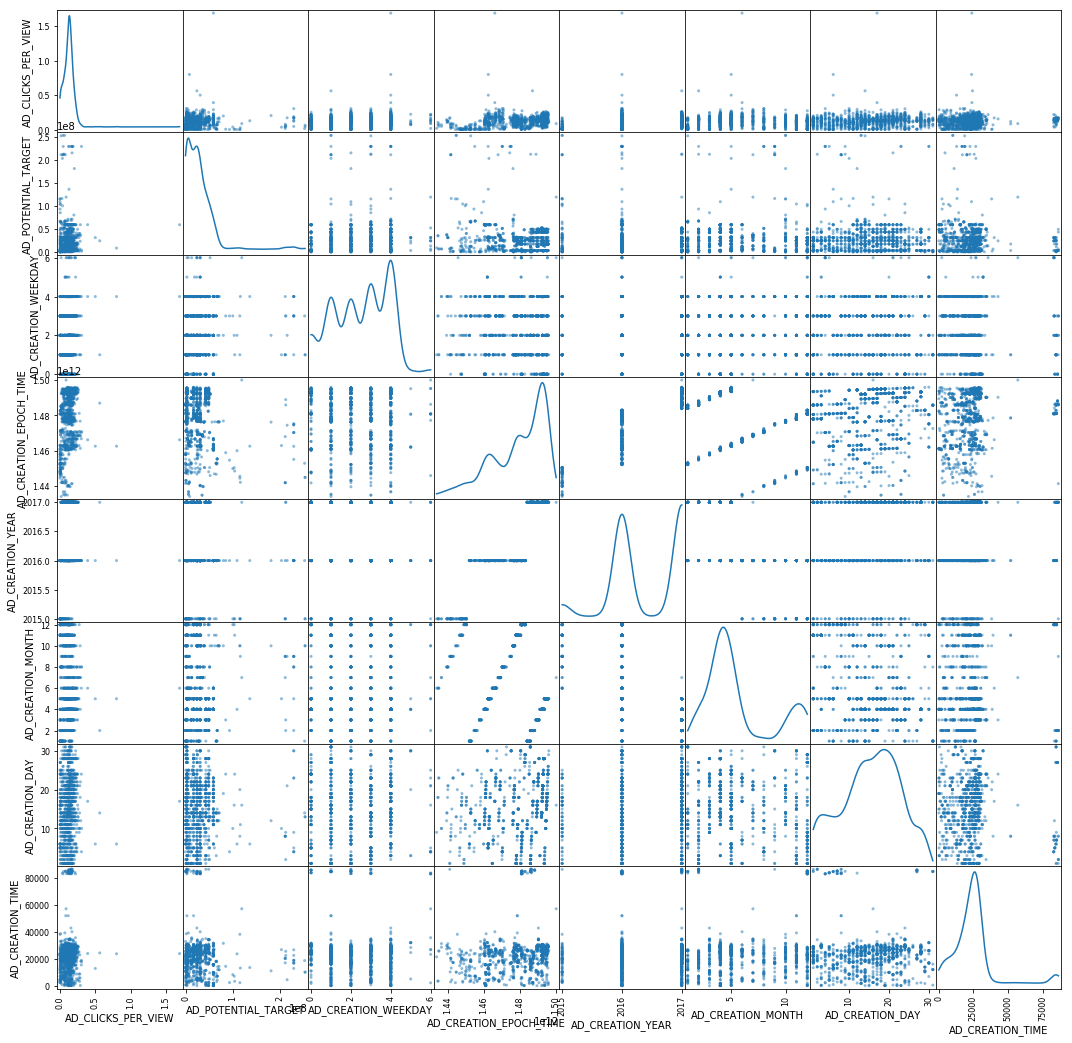

In [25]:
scatter_matrix(corrUniqueDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterUnique.png")

In [26]:
uCorr = corrUniqueDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
uCorr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.884976,0.075861,0.507308,0.056734,0.189164,0.181515,-0.074065,-0.009868,0.070263
AD_IMPRESSIONS,0.884976,1.000000,-0.071250,0.710205,0.052355,0.054802,0.057593,-0.030617,-0.027032,0.028125
AD_CLICKS_PER_VIEW,0.075861,-0.071250,1.000000,-0.122282,-0.007303,0.225997,0.218719,-0.099949,0.098993,0.074309
AD_SPEND,0.507308,0.710205,-0.122282,1.000000,0.061707,-0.078902,-0.077992,0.036807,-0.016263,-0.037918
AD_POTENTIAL_TARGET,0.056734,0.052355,-0.007303,0.061707,1.000000,-0.227568,-0.171004,-0.007134,-0.059666,-0.110472
AD_CREATION_EPOCH_TIME,0.189164,0.054802,0.225997,-0.078902,-0.227568,1.000000,0.894806,-0.270552,0.223397,0.187717
AD_CREATION_YEAR,0.181515,0.057593,0.218719,-0.077992,-0.171004,0.894806,1.000000,-0.670612,0.227297,0.101722
AD_CREATION_MONTH,-0.074065,-0.030617,-0.099949,0.036807,-0.007134,-0.270552,-0.670612,1.000000,-0.191377,0.093861
AD_CREATION_DAY,-0.009868,-0.027032,0.098993,-0.016263,-0.059666,0.223397,0.227297,-0.191377,1.000000,-0.024893
AD_CREATION_TIME,0.070263,0.028125,0.074309,-0.037918,-0.110472,0.187717,0.101722,0.093861,-0.024893,1.000000


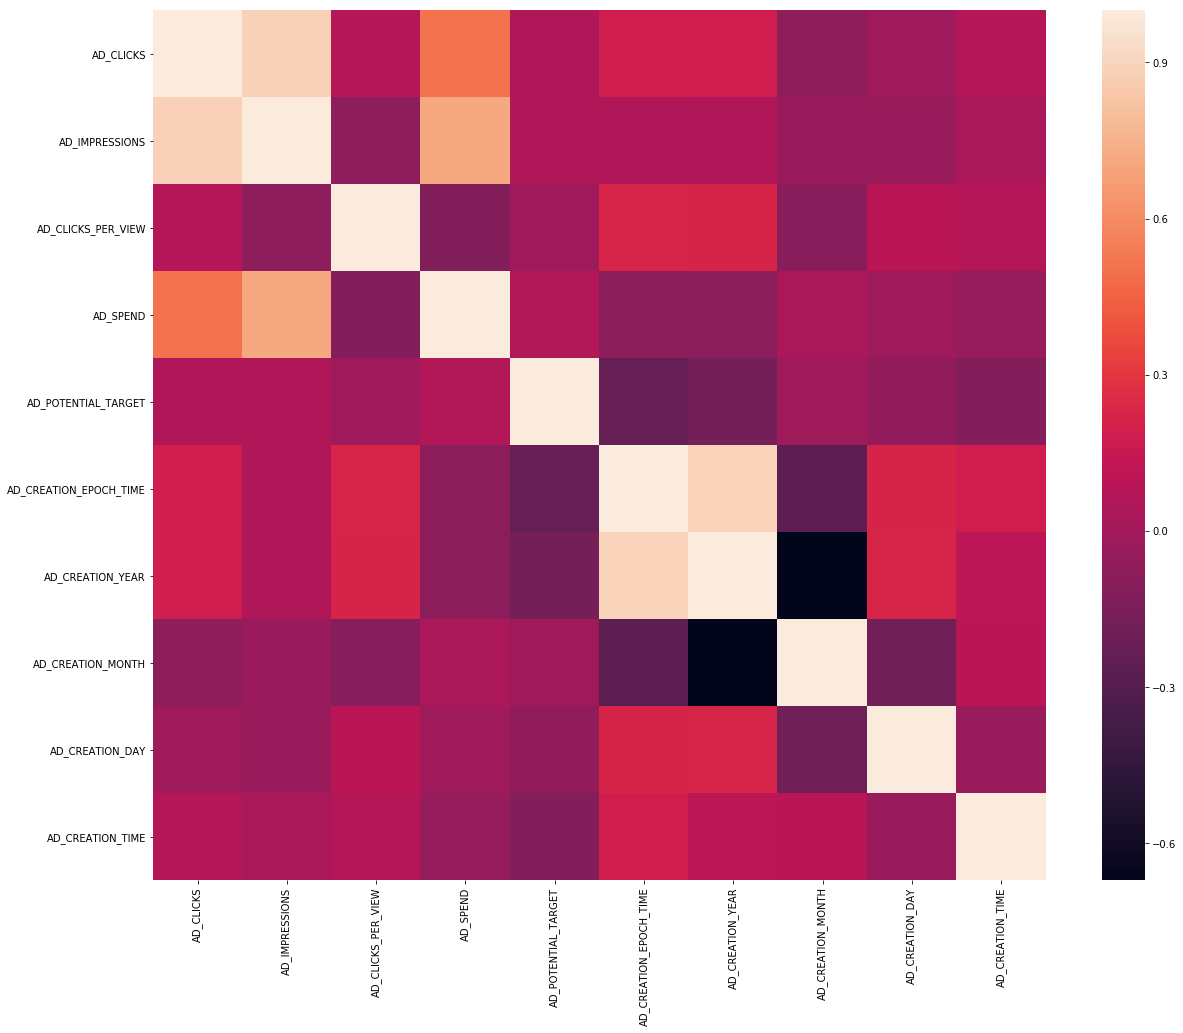

In [27]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(uCorr);

In [28]:
corrUniqueDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.884350,0.428607,0.054896
AD_IMPRESSIONS,0.884350,1.000000,0.076637,0.021602
AD_CLICKS_PER_VIEW,0.428607,0.076637,1.000000,0.087410
AD_CREATION_WEEKDAY,0.054896,0.021602,0.087410,1.000000


#### Correlation: Duplicate Dataset

In [29]:
corrDuplicateDf = ira_data[ira_data['Duplicate']==True][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

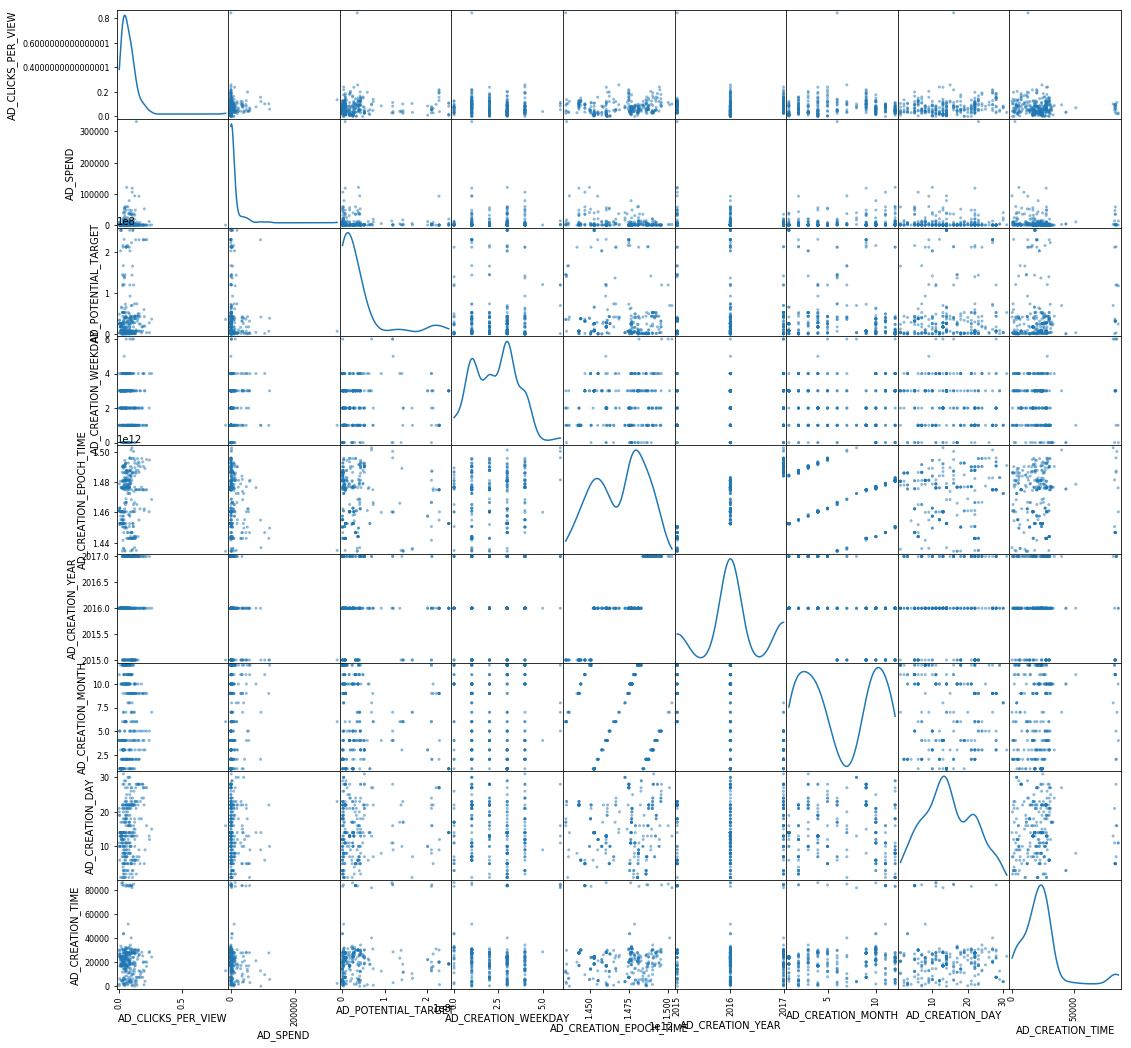

In [30]:
scatter_matrix(corrDuplicateDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND','AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterDuplicate.png")

In [31]:
dCorr = corrDuplicateDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_SPEND', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
dCorr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_SPEND,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.909774,0.093616,0.850243,-0.093571,-0.062064,0.850243,-0.128872,0.147485,-0.028145,-0.060129
AD_IMPRESSIONS,0.909774,1.000000,-0.011997,0.670095,-0.114546,-0.019111,0.670095,-0.106963,0.178899,-0.073394,-0.055375
AD_CLICKS_PER_VIEW,0.093616,-0.011997,1.000000,0.072948,0.057687,0.062275,0.072948,0.003660,0.084882,0.184900,-0.058887
AD_SPEND,0.850243,0.670095,0.072948,1.000000,-0.057980,-0.215333,1.000000,-0.242381,0.111934,-0.016227,-0.072827
AD_POTENTIAL_TARGET,-0.093571,-0.114546,0.057687,-0.057980,1.000000,-0.120589,-0.057980,-0.049660,-0.108426,0.082850,0.075011
AD_CREATION_EPOCH_TIME,-0.062064,-0.019111,0.062275,-0.215333,-0.120589,1.000000,-0.215333,0.854361,0.002781,0.081495,-0.015446
AD_SPEND,0.850243,0.670095,0.072948,1.000000,-0.057980,-0.215333,1.000000,-0.242381,0.111934,-0.016227,-0.072827
AD_CREATION_YEAR,-0.128872,-0.106963,0.003660,-0.242381,-0.049660,0.854361,-0.242381,1.000000,-0.516346,0.063797,-0.098631
AD_CREATION_MONTH,0.147485,0.178899,0.084882,0.111934,-0.108426,0.002781,0.111934,-0.516346,1.000000,-0.048783,0.166399
AD_CREATION_DAY,-0.028145,-0.073394,0.184900,-0.016227,0.082850,0.081495,-0.016227,0.063797,-0.048783,1.000000,-0.055515


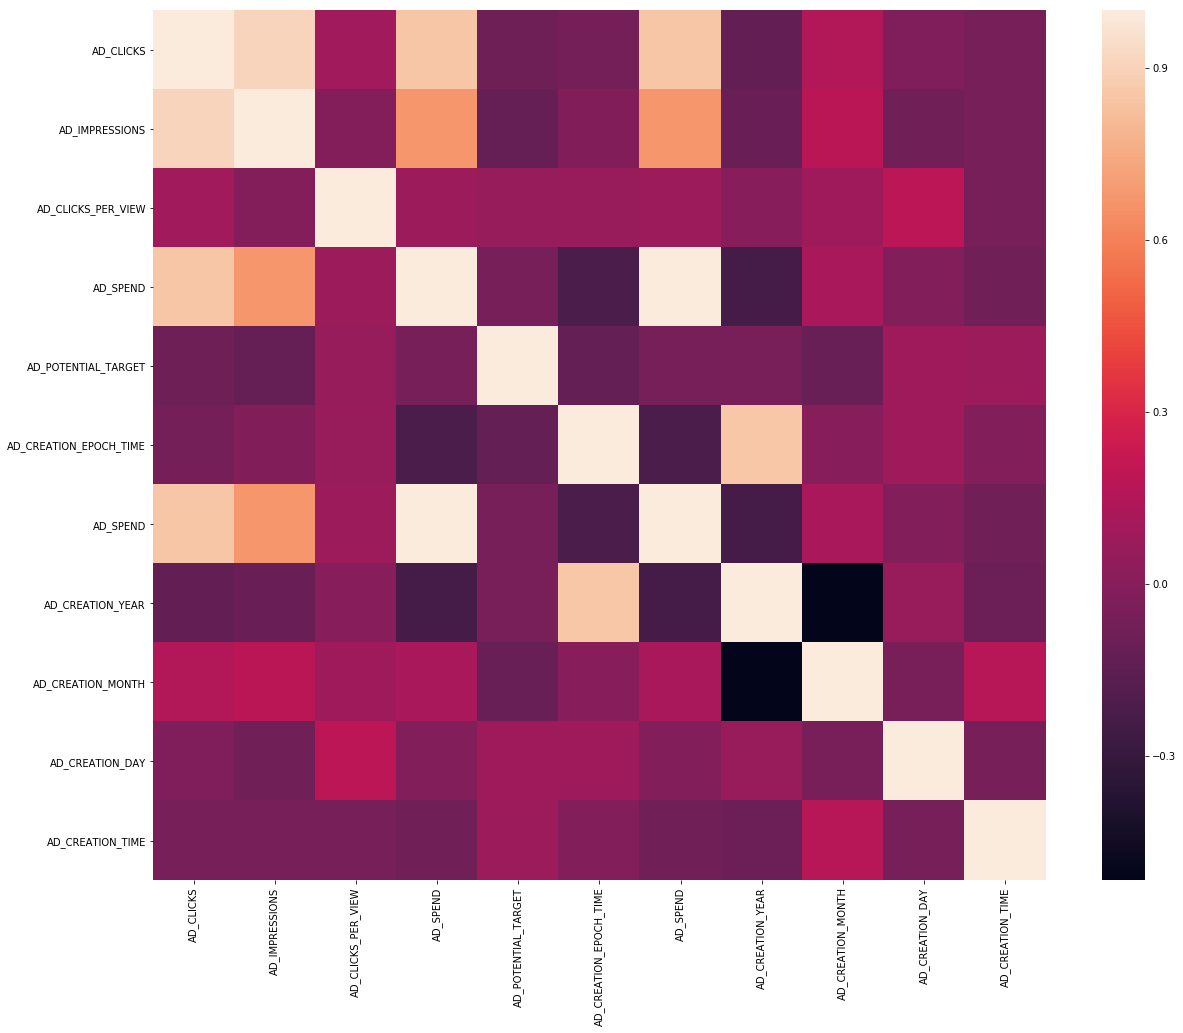

In [32]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(dCorr);

In [33]:
corrDuplicateDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.937755,0.534368,0.077878
AD_IMPRESSIONS,0.937755,1.000000,0.279715,0.139440
AD_CLICKS_PER_VIEW,0.534368,0.279715,1.000000,-0.167137
AD_CREATION_WEEKDAY,0.077878,0.139440,-0.167137,1.000000


### Regression Model (Elastic Net)
**[TODO]** ==> Julian

In [93]:
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]
X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_POTENTIAL_TARGET']]
Y= corrDf['AD_CLICKS_PER_VIEW']

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

#### Normal Multiple Linear Regression

In [97]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [102]:
y_pred = reg.predict(X_test)

In [99]:
print(reg.coef_)

[ 2.93613430e-03  1.36408794e-12 -2.61296547e-04  7.58019100e-04
  1.26911566e-10]


In [100]:
print(reg.intercept_)

-1.9248587398044505


**Very low R^2 score, so the prediction isn't very good**

In [101]:
r2_score(Y_test, y_pred)

0.12099124433983754

#### Multiple Linear Regression (Lasso)

#### Multiple Linear Regression (Ridge)

#### Multiple Linear Regression (Elastic Net)

------

In [36]:
regression=LinearRegression()
regression.fit(X,Y)
first_model=(mean_squared_error(y_true=Y,y_pred=regression.predict(X)))
print(first_model)

0.0032643934336410605


In [37]:
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AD_CREATION_WEEKDAY': 0.002601250393842456,
 'AD_CREATION_EPOCH_TIME': -7.438205343876575e-11,
 'AD_CREATION_YEAR': 2.389259283886665,
 'AD_CREATION_MONTH': 0.19904787979838323,
 'AD_CREATION_DAY': 0.0071066139515636095,
 'AD_CREATION_TIME': 2.765922573076761e-07,
 'AD_POTENTIAL_TARGET': 7.663755585506551e-11}

### ElasticNet Regression

In [38]:
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.25, random_state=1)

In [39]:
reg_1 = LinearRegression()
reg_1.fit(train_x, train_y)
reg_1.coef_

array([ 2.52066973e-03, -7.51683348e-11,  2.41142283e+00,  2.01018856e-01,
        7.25713724e-03,  3.12709212e-07,  6.57961054e-11])

In [40]:
reg_1.intercept_

-4752.466299673379

In [41]:
lm = LinearRegression()
lm_lasso = Lasso()
lm_ridge=Ridge()
lm_elastic=ElasticNet()

In [42]:
reg_1.predict(test_x)

array([0.13326826, 0.10458231, 0.10488628, 0.10280805, 0.11544972,
       0.13369319, 0.13130053, 0.14668366, 0.12412775, 0.09519909,
       0.09388311, 0.07833956, 0.14279707, 0.07004578, 0.08053061,
       0.10525574, 0.11842307, 0.13446917, 0.10431382, 0.11888136,
       0.13456873, 0.13776254, 0.13014607, 0.14621576, 0.07152018,
       0.11674391, 0.08697941, 0.12183201, 0.1037438 , 0.11695874,
       0.13352214, 0.08179181, 0.1008036 , 0.11721507, 0.13474578,
       0.14247336, 0.11008979, 0.14809889, 0.08823763, 0.17519323,
       0.13628821, 0.09351696, 0.13799555, 0.13103125, 0.12694902,
       0.13080717, 0.10344053, 0.09012766, 0.08695731, 0.13500659,
       0.14202918, 0.1428883 , 0.10775599, 0.10806078, 0.10075467,
       0.10396184, 0.08161725, 0.12746368, 0.12338977, 0.09597144,
       0.10710956, 0.14619366, 0.098874  , 0.09120679, 0.09274418,
       0.09983992, 0.1194516 , 0.13240394, 0.12645655, 0.10114489,
       0.10390815, 0.08662707, 0.11005149, 0.11649935, 0.10896

In [43]:
lm.fit(train_x, train_y)
lm_lasso.fit(train_x, train_y)
lm_ridge.fit(train_x, train_y)
lm_elastic.fit(train_x, train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.39196e-24): result may not be accurate.
  overwrite_a=True).T


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

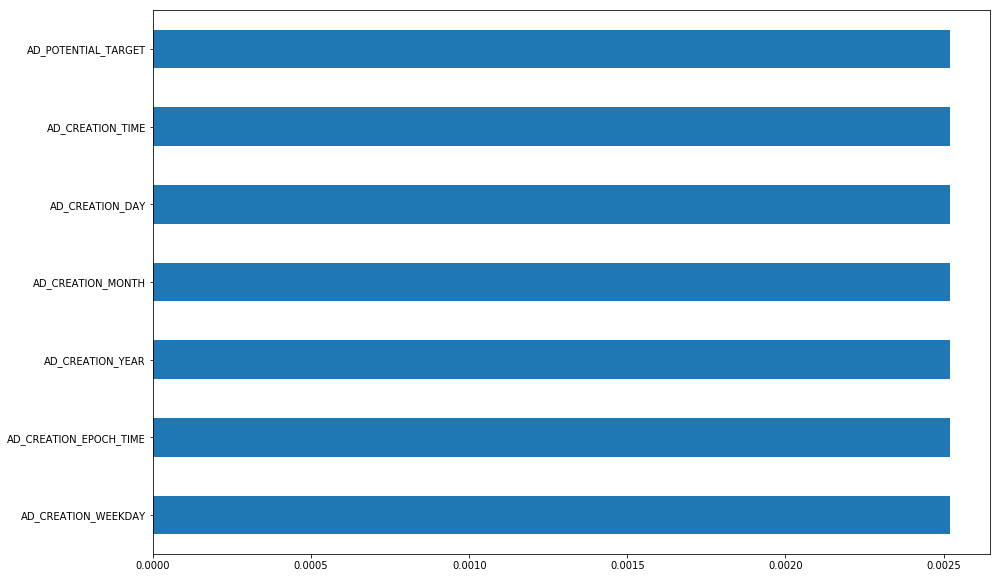

In [44]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm.coef_[0], index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

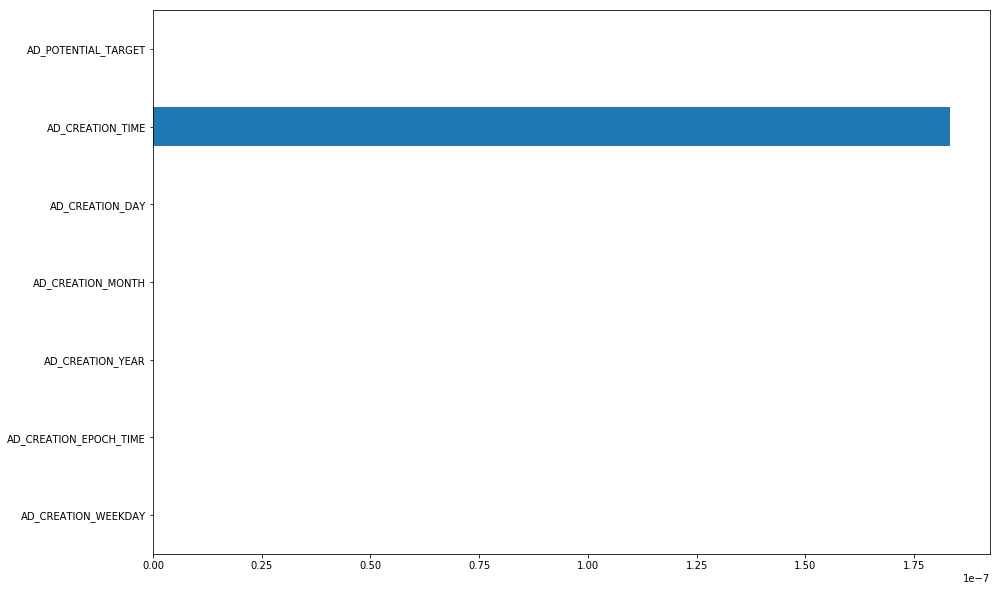

In [45]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm_lasso.coef_, index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

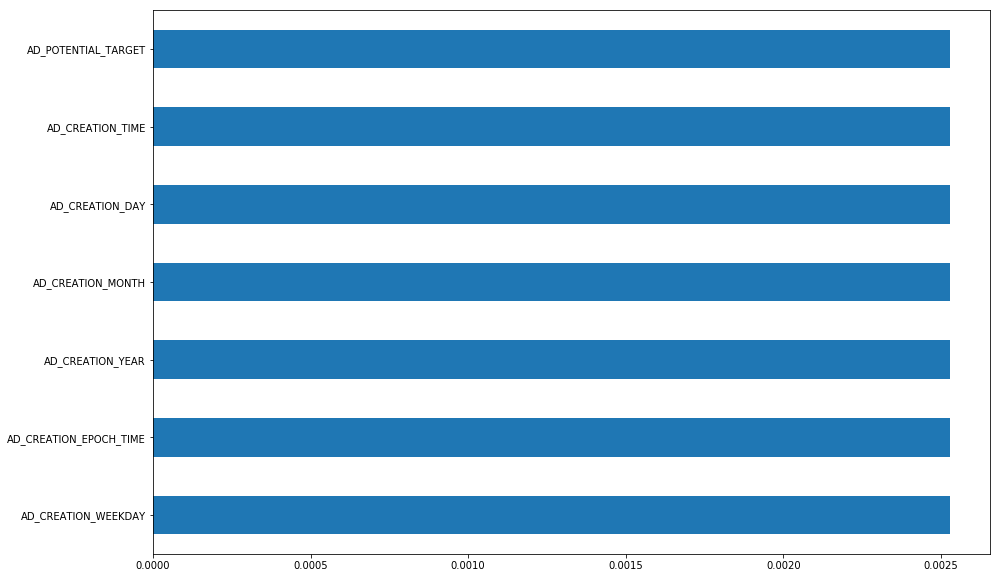

In [46]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm_ridge.coef_[0], index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

In [47]:
lm_elastic.coef_

array([ 0.00000000e+00,  1.36031612e-12,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.85562578e-07,  1.18936678e-10])

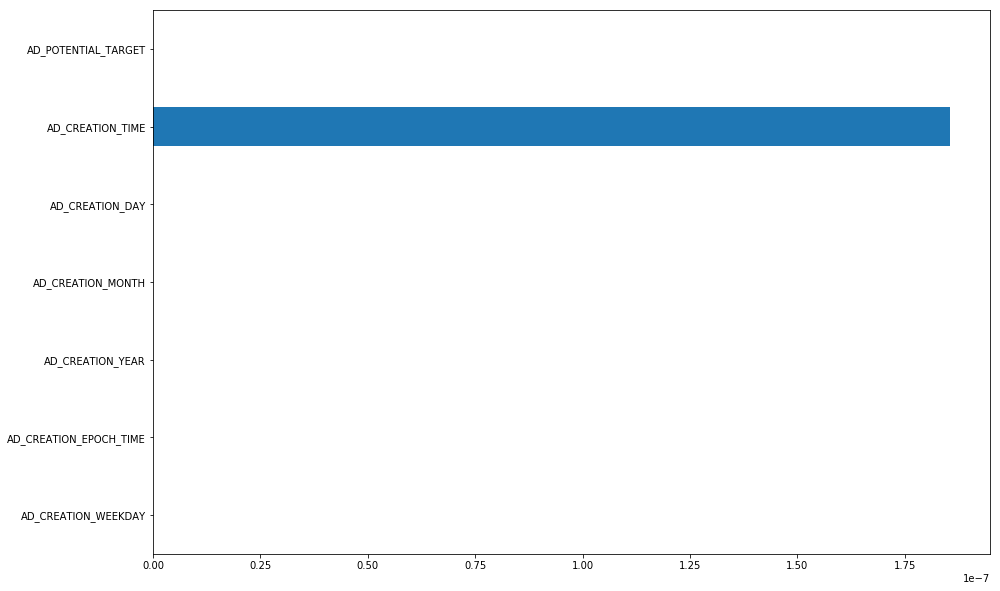

In [48]:
plt.figure(figsize=(15,10))
ft_importances_lm = pd.Series(lm_elastic.coef_, index = X.columns)
ft_importances_lm.plot(kind='barh')
plt.show();

In [49]:
print("RSquare Value for Simple Regression TEST data is-")
print(np.round(lm.score(test_x,test_y)*100,2))

print("RSquare Value for Lasso Regression TEST data is-")
print(np.round(lm_lasso.score(test_x,test_y)*100,2))

print("RSquare Value for Ridge Regression TEST data is-")
print(np.round(lm_ridge.score(test_x,test_y)*100,2))

print("RSquare Value for Elastic Regression TEST data is-")
print(np.round(lm_elastic.score(test_x,test_y)*100,2))

RSquare Value for Simple Regression TEST data is-
16.08
RSquare Value for Lasso Regression TEST data is-
15.13
RSquare Value for Ridge Regression TEST data is-
15.67
RSquare Value for Elastic Regression TEST data is-
15.13


In [50]:
predict_test_lm = lm.predict(test_x)
predict_test_lm_lasso = lm_lasso.predict(test_x)
predict_test_lm_ridge = lm_ridge.predict(test_x)
predict_test_lm_elastic = lm_elastic.predict(test_x)

In [51]:
print("Simple Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm),2))

print("Lasso Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm_lasso),2))

print("Ridge Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm_ridge),2))

print("Elastic Regression Mean Square Error (MSE) for TEST data is")
print(np.round(mean_squared_error(test_y, predict_test_lm_elastic),2))

Simple Regression Mean Square Error (MSE) for TEST data is
0.0
Lasso Regression Mean Square Error (MSE) for TEST data is
0.0
Ridge Regression Mean Square Error (MSE) for TEST data is
0.0
Elastic Regression Mean Square Error (MSE) for TEST data is
0.0


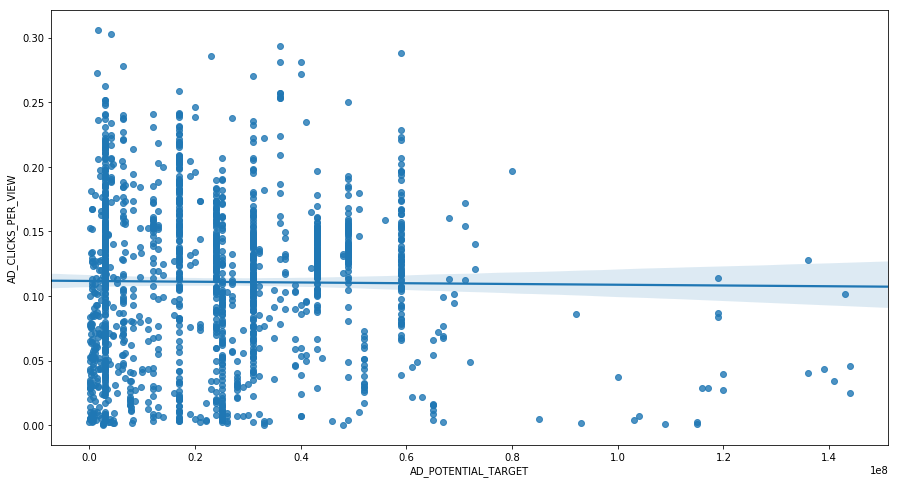

In [52]:
sns.regplot(x="AD_POTENTIAL_TARGET", y="AD_CLICKS_PER_VIEW", data=corrDf)

In [53]:
elastic=ElasticNet(normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [54]:
search.fit(X,Y)
search.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.4}

In [55]:
abs(search.best_score_)

0.0034613729751752772

In [56]:
elastic=ElasticNet(normalize=True,alpha=0.0001,l1_ratio=0.4)
elastic.fit(X,Y)
second_model=(mean_squared_error(y_true=Y,y_pred=elastic.predict(X)))
print(second_model)

0.0033033087318236325


In [57]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AD_CREATION_WEEKDAY': 0.0015667913210746177,
 'AD_CREATION_EPOCH_TIME': 9.17462784376555e-13,
 'AD_CREATION_YEAR': 0.007353783093371625,
 'AD_CREATION_MONTH': 0.0,
 'AD_CREATION_DAY': 0.0005073948549479813,
 'AD_CREATION_TIME': 9.891331520296856e-08,
 'AD_POTENTIAL_TARGET': 1.036939350150669e-11}

### Polynomial Regression

In [58]:
def pol_regression(X, Y):
    transformer = PolynomialFeatures(degree=2, include_bias=True)
    transformer.fit(X)
    X_ = transformer.transform(X)
    model = LinearRegression()
    model.fit(X_, Y)
    intercept, coefficients = model.intercept_, model.coef_
    r_sq = model.score(X_, Y)
    y_pred = model.predict(X_)
    return dict([('intercept', intercept), ('coefficients', coefficients), ('r_sq', r_sq), ('pred', y_pred)])

In [59]:
print(pol_regression(X, Y))

{'intercept': -18.194537165387242, 'coefficients': array([-1.11871103e-12, -1.00336729e-12, -3.55541147e-13,  1.81781240e-18,
        5.03453596e-19, -2.35621436e-19, -2.51913082e-17,  5.68697041e-15,
       -9.13004858e-18,  3.09622499e-15, -1.25264628e-16, -1.85697474e-17,
       -8.10013404e-18,  1.09670750e-14, -6.68321233e-11, -7.72522239e-24,
        1.19658939e-14,  6.26135281e-16,  7.02154762e-16,  1.15314690e-19,
       -1.26587544e-20,  1.90338849e-17, -8.95443500e-17, -3.87725620e-16,
       -4.93394935e-14,  9.78402840e-12, -4.34200038e-18, -4.36186658e-17,
        1.42982786e-14,  1.71275261e-11, -6.07504022e-17, -4.33928193e-14,
       -8.63663678e-12,  1.70046435e-12, -2.83653117e-15, -8.90584458e-18]), 'r_sq': 0.16447513621898924, 'pred': array([0.09201692, 0.07024167, 0.07473972, ..., 0.13851094, 0.09357651,
       0.1370046 ])}


### Regression with statsmodels

In [60]:
X_train = X[:-50]
X_test = X[-50:]

In [61]:
y_train = Y[:-50]
y_test = Y[-50:]

In [62]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [63]:
y_pred = model.predict(X_test)

In [64]:
# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 2.04184168e-03 -7.26171649e-11  2.33568696e+00  1.94175158e-01
  6.96470165e-03  2.73856617e-07  1.58900117e-10]
Mean squared error: 0.01
Variance score: -1.84


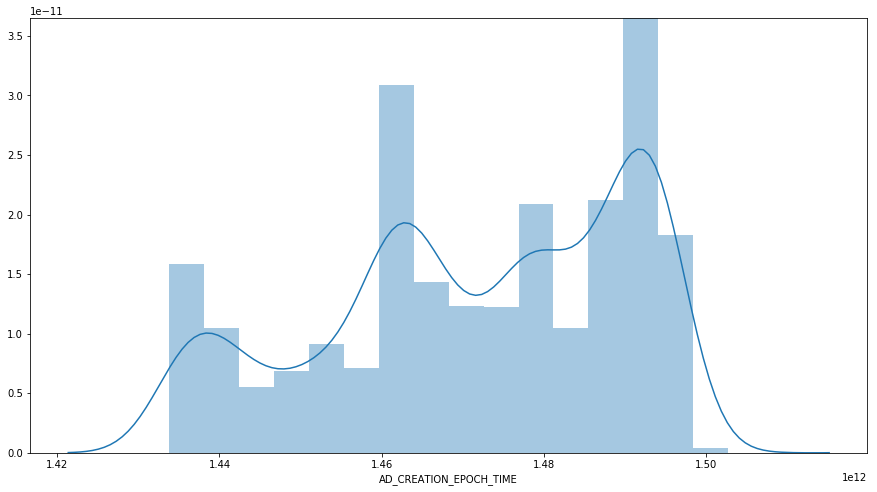

In [65]:
sns.distplot(ira_data['AD_CREATION_EPOCH_TIME'].dropna())

In [66]:
ira_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 1 to 3517
Data columns (total 31 columns):
AD_CLICKS                              2395 non-null float64
AD_CREATION_DATE                       2395 non-null datetime64[ns]
AD_END_DATE                            1803 non-null datetime64[ns]
AD_IMPRESSIONS                         2395 non-null float64
AD_LANDING_PAGE                        2378 non-null object
AD_CLICKS_PER_VIEW                     2395 non-null float64
AD_PATH                                2395 non-null object
AD_SPEND                               2385 non-null float64
AD_TARGETING_AGE                       2395 non-null object
AD_TARGETING_CUSTOM_AUDIENCE           24 non-null object
AD_TARGETING_EXCLUDE                   62 non-null object
AD_TARGETING_EXCLUDED_CONNECTIONS      519 non-null object
AD_TARGETING_EXCLUDE_LOCATION          2 non-null object
AD_TARGETING_FRIENDS_OF_CONNECTIONS    347 non-null object
AD_TARGETING_GENDER                    38 

count    2395.000000
mean        0.107085
std         0.076755
min         0.000030
25%         0.054642
50%         0.105732
75%         0.146752
max         1.690789
Name: AD_CLICKS_PER_VIEW, dtype: float64


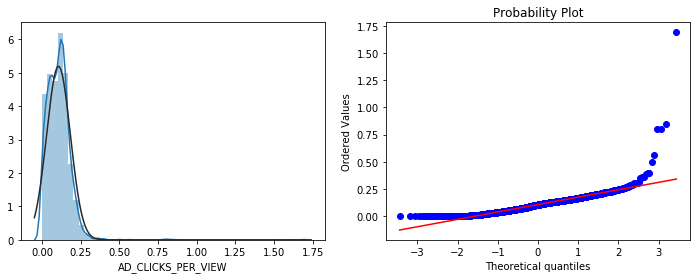

In [67]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)

In [68]:
cpv = ira_data.AD_CLICKS_PER_VIEW
ira_data.AD_CLICKS_PER_VIEW = np.log(cpv)

count    2395.000000
mean       -2.575177
std         1.065514
min       -10.409793
25%        -2.906958
50%        -2.246849
75%        -1.919010
max         0.525196
Name: AD_CLICKS_PER_VIEW, dtype: float64


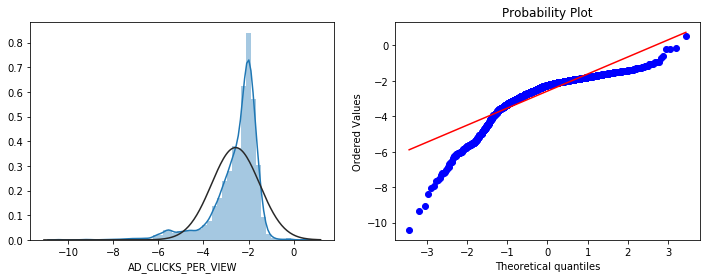

In [69]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)